### Modelo clásico (SVM) con feature extraction

### IMPORT LIBRARIES

In [10]:
import os, io, random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from collections import Counter
import pathlib, shutil
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.measure import shannon_entropy

### LOAD DATA

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wanderdust/skin-lesion-analysis-toward-melanoma-detection")

print("Path to dataset files:", path)

Path to dataset files: /Users/blancasl01/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1


In [3]:
# Preprocesamiento y carga del dataset
train_dir = '/Users/blancasl01/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1/skin-lesions/train'
validation_dir = '/Users/blancasl01/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1/skin-lesions/valid'
test_dir = '/Users/blancasl01/.cache/kagglehub/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection/versions/1/skin-lesions/test'

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(224, 224),
    batch_size=32,
)


test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
)

Found 2000 files belonging to 3 classes.
Found 150 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


Defino las clases

In [4]:
classes = ['melanoma', 'seborrheic_keratosis', 'nevus']

### FEATURE EXTRACTION

Se procesan todas las imágenes para construir un vector de características por imagen. 
Se combinan tres tipos de información:

Forma: usando HOG (Histogram of Oriented Gradients) sobre una versión en escala de grises de la imagen.

Color: media y desviación típica de los canales R, G y B.

Textura: entropía de Shannon como medida global de complejidad.

Cada imagen queda representada por un único vector numérico que resume su estructura, color y textura. Estos vectores se usarán como entrada para los modelos clásicos de clasificación.

In [5]:
def extract_features_from_dataset(dataset, img_size=(224, 224)):
    X = []
    y = []

    for batch in dataset:
        images, labels = batch
        for img_tensor, label in zip(images, labels):
            img = img_tensor.numpy().astype('uint8')
            img_resized = cv2.resize(img, img_size)
            gray = rgb2gray(img_resized) if img_resized.ndim == 3 else img_resized
            hog_feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)

            if img_resized.ndim == 3:
                r_mean, g_mean, b_mean = np.mean(img_resized, axis=(0, 1))
                r_std, g_std, b_std = np.std(img_resized, axis=(0, 1))
            else:
                r_mean = g_mean = b_mean = np.mean(img_resized)
                r_std = g_std = b_std = np.std(img_resized)

            entropy = shannon_entropy(gray)
            extra_features = [r_mean, g_mean, b_mean, r_std, g_std, b_std, entropy]
            full_features = np.concatenate([hog_feat, extra_features])

            X.append(full_features)
            y.append(label.numpy())

    return np.array(X), np.array(y)

In [11]:
X_train, y_train = extract_features_from_dataset(train_dataset)
X_val, y_val     = extract_features_from_dataset(validation_dataset)
X_test, y_test   = extract_features_from_dataset(test_dataset)

2025-05-03 21:03:05.388365: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-03 21:03:18.059858: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### ENTRENO DEL MODELO DE ML

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

clf = SVC(kernel='linear', C=0.1,class_weight='balanced')
clf.fit(X_train, y_train)

SVC(C=0.1, class_weight='balanced', kernel='linear')

In [13]:
# EVALUACIÓN EN TRAIN
y_train_pred = clf.predict(X_train)
print("Resultados en TRAIN:")
print(classification_report(y_train, y_train_pred, target_names=classes))

# EVALUACIÓN EN VALIDATION
y_val_pred = clf.predict(X_val)
print("Resultados en VALIDATION:")
print(classification_report(y_val, y_val_pred, target_names=classes))

Resultados en TRAIN:
                      precision    recall  f1-score   support

            melanoma       0.69      0.94      0.80       374
seborrheic_keratosis       0.98      0.84      0.90      1372
               nevus       0.79      1.00      0.89       254

            accuracy                           0.88      2000
           macro avg       0.82      0.93      0.86      2000
        weighted avg       0.90      0.88      0.88      2000

Resultados en VALIDATION:
                      precision    recall  f1-score   support

            melanoma       0.33      0.40      0.36        30
seborrheic_keratosis       0.77      0.64      0.70        78
               nevus       0.51      0.60      0.55        42

            accuracy                           0.58       150
           macro avg       0.54      0.55      0.54       150
        weighted avg       0.61      0.58      0.59       150



Evaluación final en TEST:
                      precision    recall  f1-score   support

            melanoma       0.27      0.44      0.34       117
seborrheic_keratosis       0.81      0.48      0.60       393
               nevus       0.31      0.62      0.42        90

            accuracy                           0.49       600
           macro avg       0.47      0.51      0.45       600
        weighted avg       0.63      0.49      0.52       600



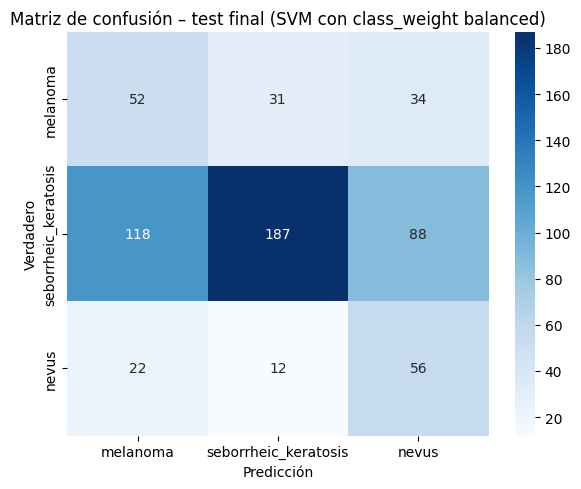

In [14]:
y_test_pred = clf.predict(X_test)

print("Evaluación final en TEST:")
print(classification_report(y_test, y_test_pred, target_names=classes))

# Matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Matriz de confusión – test final (SVM con class_weight balanced)")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.tight_layout()
plt.show()

### RESULTADOS DEL MODELO

### Evaluación del modelo clásico (SVM con HOG + color + textura)

Inicialmente, se entrenó un modelo SVM con `kernel='linear'` y los hiperparámetros por defecto, es decir, `C=1`. Este modelo alcanzó un 100 % de accuracy en el conjunto de entrenamiento, lo que mostró un sobreajuste extremo. Sin embargo, su rendimiento en los conjuntos de validación y test fue significativamente inferior (accuracy del 53 % y 50 % respectivamente), lo que indicaba que el modelo no generalizaba bien a datos nuevos.

Para mitigar este sobreajuste, se redujo el valor de `C` a `0.1`, lo que incrementa la regularización y permite al modelo ser más tolerante a errores durante el entrenamiento. Esta modificación provocó un descenso razonable del rendimiento en `train` (accuracy del 88 %), pero una mejora notable en `validation` (58 %) y en `test` (49 %).

Este nuevo modelo, aunque no logra una precisión elevada, refleja mejor la complejidad del problema y ofrece un rendimiento más equilibrado entre los distintos conjuntos. Sirve como un punto de base razonable para comparar con modelos más potentes como CNN o redes preentrenadas.